1.**Data Loading and Imports**

In [59]:
#  Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#  Setup
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

#  Load datasets
train_df = pd.read_csv("/kaggle/input/personality-prediciton/train.csv")
test_df = pd.read_csv("/kaggle/input/personality-prediciton/test.csv")
submission_df = pd.read_csv("/kaggle/input/personality-prediciton/sample_submission.csv")

#  Preview
train_df.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


2.**EDA + Target Distribution + Missing Values Visualization?**

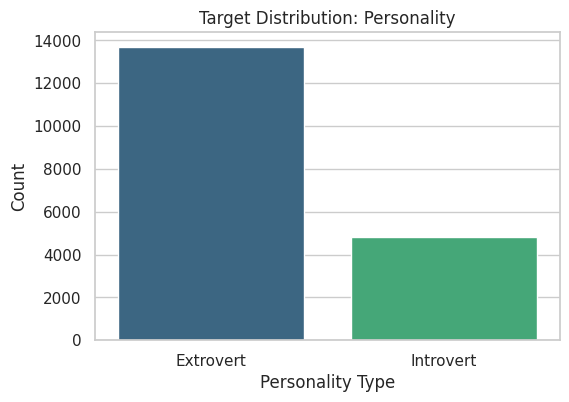

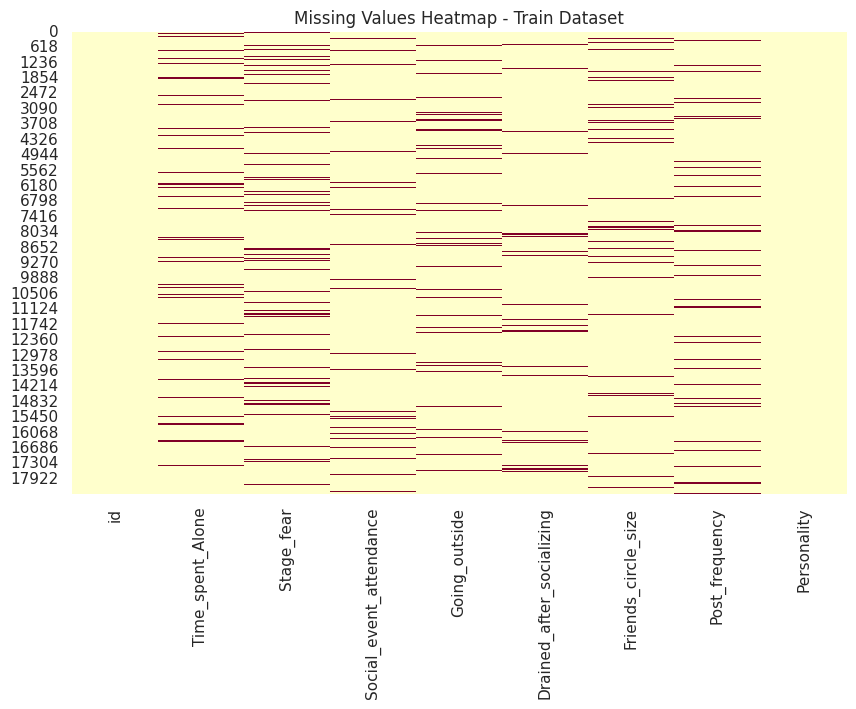

Stage_fear                   10.219175
Going_outside                 7.914057
Post_frequency                6.823580
Time_spent_Alone              6.424098
Social_event_attendance       6.370114
Drained_after_socializing     6.202764
Friends_circle_size           5.689916
dtype: float64

In [60]:
#  Target distribution
target_counts = train_df['Personality'].value_counts()

# Barplot of target
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")
plt.title("Target Distribution: Personality")
plt.ylabel("Count")
plt.xlabel("Personality Type")
plt.show()

#  Missing values heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap="YlOrRd")
plt.title("Missing Values Heatmap - Train Dataset")
plt.show()

#  Percentage of missing values
missing_percent = train_df.isnull().mean().sort_values(ascending=False) * 100
missing_percent[missing_percent > 0]


3.**Preprocessing + Encoding + Imputation, optimized for modeling**

In [61]:
#  Drop ID columns (keep for later joining submission)
train_ids = train_df['id']
test_ids = test_df['id']
train_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)

#  Encode target
label_encoder = LabelEncoder()
train_df['Personality'] = label_encoder.fit_transform(train_df['Personality'])  # Extrovert = 0, Introvert = 1

#  Separate features and target
X = train_df.drop(columns=['Personality'])
y = train_df['Personality']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['float64', 'int']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

#  Imputation strategy
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Apply imputers
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])
test_df[numerical_cols] = num_imputer.transform(test_df[numerical_cols])
test_df[categorical_cols] = cat_imputer.transform(test_df[categorical_cols])

# Encode categorical variables (Yes/No → 1/0)
for col in categorical_cols:
    X[col] = X[col].map({'Yes': 1, 'No': 0})
    test_df[col] = test_df[col].map({'Yes': 1, 'No': 0})

#  Final shape check
print(" Train shape:", X.shape)
print(" Test shape:", test_df.shape)


✅ Train shape: (18524, 7)
✅ Test shape: (6175, 7)


4. **Model Training with XGBoost + Validation**

In [62]:
#  Train-test split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#  XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=220,
    learning_rate=0.09,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=3,
    random_state=34,
    use_label_encoder=False,
    eval_metric='auc'
)

# Train with early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=15,
    verbose=False
)

# 📈 Evaluate on validation set
val_preds = xgb_model.predict(X_val)

print("🔍 Accuracy:", accuracy_score(y_val, val_preds))
print("\n🧾 Classification Report:\n", classification_report(y_val, val_preds, target_names=label_encoder.classes_))


🔍 Accuracy: 0.9713900134952766

🧾 Classification Report:
               precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2740
   Introvert       0.94      0.95      0.95       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


5. **Submission File**

In [63]:
#  Predict on test set
test_preds = xgb_model.predict(test_df)

#  Convert predictions back to original labels (Extrovert/Introvert)
test_preds_labels = label_encoder.inverse_transform(test_preds)

#  Prepare submission
submission = pd.DataFrame({
    'id': test_ids,
    'Personality': test_preds_labels
})

#  Save to CSV
submission.to_csv("submission.csv", index=False)

#  Preview
submission.head()


,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert
